In [19]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Run ONCE (per machine/env)
QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token="",
    instance="",  # your CRN
    overwrite=True,
    set_as_default=True
)

InvalidAccountError: "Invalid `token` value. Expected a non-empty string, got ''."

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Run every time you need the service
service = QiskitRuntimeService()

# Mapping

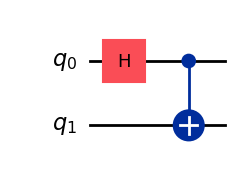

In [6]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl").
# These guides are written by using Jupyter notebooks, which
# display the output of the last line of each cell.
# If you're running this in a script, use `print(qc.draw())` to
# print a text drawing.
qc.draw("mpl")

## Observables to measure

In [3]:
# Set up six different observables.
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

# Optimize

In [ ]:
# !pip install qiskit
from qiskit import QuantumCircuit, Aer, execute
import random

def encode_qubit(bit, basis):
    """
    Returns a circuit that prepares a single-qubit state for the given bit and basis.
    basis 'Z': 0 -> |0>, 1 -> |1>
    basis 'X': 0 -> |+>, 1 -> |->
    """
    qc = QuantumCircuit(1, 1)
    if basis == 'Z':
        if bit == 1:
            qc.x(0)           # |1>
    elif basis == 'X':
        qc.h(0)               # |+>
        if bit == 1:
            qc.z(0)           # |-> = Z|+>
    else:
        raise ValueError("basis must be 'Z' or 'X'")
    return qc

def measure_in_basis(circ, basis):
    """
    Appends measurement in the chosen basis to a 1-qubit circuit.
    For X basis, rotate with H before measuring in Z.
    """
    qc = circ.copy()
    if basis == 'X':
        qc.h(0)
    qc.measure(0, 0)
    return qc

def bb84_qiskit(n=200, shots=1, eve_attack=False, seed=None):
    if seed is not None:
        random.seed(seed)

    backend = Aer.get_backend('qasm_simulator')
    alice_bits  = [random.randint(0,1) for _ in range(n)]
    alice_bases = [random.choice(['Z','X']) for _ in range(n)]
    bob_bases   = [random.choice(['Z','X']) for _ in range(n)]

    eve_bases = [random.choice(['Z','X']) for _ in range(n)] if eve_attack else [None]*n

    bob_results = []
    for i in range(n):
        # Prepare what is sent
        if eve_attack:
            # Alice encodes, Eve measures, resends
            circ_a = encode_qubit(alice_bits[i], alice_bases[i])
            # Eve measures in eve_bases[i]
            circ_eve = measure_in_basis(circ_a, eve_bases[i])
            job_eve = execute(circ_eve, backend=backend, shots=1, seed_simulator=seed)
            eve_out = int(list(job_eve.result().get_counts().keys())[0])

            # Eve resends a state consistent with her outcome and her basis
            circ_send = encode_qubit(eve_out, eve_bases[i])
        else:
            # No Eve: send Alice's prepared qubit
            circ_send = encode_qubit(alice_bits[i], alice_bases[i])

        # Bob measures in his basis
        circ_bob = measure_in_basis(circ_send, bob_bases[i])
        job_bob = execute(circ_bob, backend=backend, shots=shots, seed_simulator=seed)
        counts  = job_bob.result().get_counts()
        # Majority vote if shots > 1
        bob_bit = 1 if counts.get('1',0) > counts.get('0',0) else 0
        bob_results.append(bob_bit)

    # Sifting
    sift_idx = [i for i in range(n) if alice_bases[i] == bob_bases[i]]
    sifted_alice = [alice_bits[i] for i in sift_idx]
    sifted_bob   = [bob_results[i] for i in sift_idx]

    # Sample to estimate QBER
    sample_size = max(1, len(sift_idx)//5) if sift_idx else 0
    sample_positions = random.sample(range(len(sift_idx)), sample_size) if len(sift_idx) >= sample_size and sample_size>0 else []
    errors = sum(1 for j in sample_positions if sifted_alice[j] != sifted_bob[j])
    qber = errors/len(sample_positions) if sample_positions else 0.0

    remaining_key = [sifted_alice[j] for j in range(len(sift_idx)) if j not in sample_positions]

    return {
        "sifted_len": len(sift_idx),
        "qber_estimate": qber,
        "remaining_key_len": len(remaining_key),
        "sifted_alice": sifted_alice,
        "sifted_bob": sifted_bob,
        "remaining_key": remaining_key
    }

# Demo
print("No Eve:")
print(bb84_qiskit(n=200, shots=1, eve_attack=False, seed=7))
print("\nWith intercept-resend Eve:")
print(bb84_qiskit(n=200, shots=1, eve_attack=True, seed=7))


# BB84 code

In [6]:
from qiskit_aer import Aer

In [8]:
# BB84 end-to-end over IBM Quantum backends (QiskitRuntimeService)
# - Uses IBM backends for actual qubit sampling (simulator or hardware)
# - Optional intercept-resend Eve is implemented via two backend runs
#
# Requirements:
#   pip install qiskit qiskit-ibm-runtime
#
# Auth setup (one-time):
#   from qiskit_ibm_runtime import QiskitRuntimeService
#   QiskitRuntimeService.save_account(token="YOUR_API_KEY", instance="YOUR_INSTANCE")
#
# Then just run this script.

from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
import random, math, hashlib
from typing import List, Tuple, Dict

# ---------- helpers ----------

# Upper-bound Eve's info during privacy amplification
def h2(p: float) -> float:
    """Binary entropy (bits)."""
    if p <= 0.0 or p >= 1.0:
        return 0.0
    return -p*math.log2(p) - (1-p)*math.log2(1-p)

# XOR of a list of bits during error correction
def parity(bits: List[int]) -> int:
    acc = 0
    for b in bits:
        acc ^= (b & 1)
    return acc

# Pakc a list of bits into bytes
def bits_to_bytes(bits: List[int]) -> bytes:
    if not bits:
        return b""
    out = bytearray((len(bits) + 7) // 8)
    for i, b in enumerate(bits):
        if b & 1:
            out[i // 8] |= (1 << (7 - (i % 8)))
    return bytes(out)

def hash_stream(seed_bytes: bytes, total_bits: int) -> List[int]:
    """Deterministic bitstream via repeated SHA-256(seed || counter)."""
    out_bits: List[int] = []
    counter = 0
    while len(out_bits) < total_bits:
        h = hashlib.sha256(seed_bytes + counter.to_bytes(4, 'big')).digest()
        for byte in h:
            for bitpos in range(7, -1, -1):
                out_bits.append((byte >> bitpos) & 1)
                if len(out_bits) == total_bits:
                    break
            if len(out_bits) == total_bits:
                break
        counter += 1
    return out_bits

# ---------- QKD primitives on a backend ----------

# 
def encode_qubit(bit: int, basis: str) -> QuantumCircuit:
    """
    Prepare one qubit in Z or X basis:
      Z: 0 -> |0>, 1 -> |1>
      X: 0 -> |+>, 1 -> |->
    Measurement is added later.
    """
    qc = QuantumCircuit(1, 1)
    if basis == 'Z':
        if bit == 1:
            qc.x(0)
    elif basis == 'X':
        qc.h(0)      # |+>
        if bit == 1:
            qc.z(0)  # |->
    else:
        raise ValueError("basis must be 'Z' or 'X'")
    return qc

def measure_in_basis(qc: QuantumCircuit, basis: str) -> QuantumCircuit:
    """Append measurement in Z; if X basis is desired, rotate by H then measure Z."""
    circ = qc.copy()
    if basis == 'X':
        circ.h(0)
    circ.measure(0, 0)
    return circ

def run_single_shot_batch(backend, circuits: List[QuantumCircuit]) -> List[int]:
    """
    Run a batch of 1-qubit measurement circuits with shots=1 and return
    a list of 0/1 outcomes (majority vote would be trivial with shots>1).
    """
    tc = transpile(circuits, backend=backend)
    job = backend.run(tc, shots=1)
    result = job.result()
    outs = []
    # result.get_counts(i) returns a dict like {'0': 1} or {'1': 1}
    for i in range(len(circuits)):
        counts = result.get_counts(i)
        bit = 1 if counts.get('1', 0) >= counts.get('0', 0) else 0
        outs.append(bit)
    return outs

# ---------- classical steps: sifting, sampling, EC, PA ----------

def sifting(alice_bits: List[int], alice_bases: List[str],
            bob_bases: List[str], bob_results: List[int]
    ) -> Tuple[List[int], List[int], List[int]]:
    idx = [i for i in range(len(alice_bits)) if alice_bases[i] == bob_bases[i]]
    siftA = [alice_bits[i] for i in idx]
    siftB = [bob_results[i] for i in idx]
    return idx, siftA, siftB

def sample_qber(siftA: List[int], siftB: List[int], sample_ratio: float, rng: random.Random
    ) -> Tuple[float, List[int], List[int], int]:
    m = len(siftA)
    if m == 0:
        return 0.0, [], [], 0
    k = max(1, int(sample_ratio * m))
    positions = rng.sample(range(m), k) if m >= k else list(range(m))
    errors = sum(1 for j in positions if siftA[j] != siftB[j])
    qber = errors / len(positions) if positions else 0.0
    pos_set = set(positions)
    A_rem = [siftA[j] for j in range(m) if j not in pos_set]
    B_rem = [siftB[j] for j in range(m) if j not in pos_set]
    return qber, A_rem, B_rem, len(positions)

def binary_search_fix(A: List[int], B: List[int], start: int, end: int, rng: random.Random
    ) -> Tuple[int, int]:
    leak = 0
    l, r = start, end
    while r - l > 1:
        mid = (l + r) // 2
        pA = parity(A[l:mid])
        pB = parity(B[l:mid])
        leak += 1
        if pA != pB:
            r = mid
        else:
            l = mid
    B[l] ^= 1
    return leak, 1

def cascade_reconcile(A: List[int], B: List[int], passes: int, block_size: int, rng: random.Random
    ) -> Tuple[List[int], List[int], int]:
    A_cur = A[:]
    B_cur = B[:]
    leak = 0
    n = len(A_cur)
    if n == 0:
        return A_cur, B_cur, leak
    for _ in range(max(1, passes)):
        perm = list(range(n))
        rng.shuffle(perm)
        inv = [0]*n
        for i, p in enumerate(perm):
            inv[p] = i
        A_p = [A_cur[p] for p in perm]
        B_p = [B_cur[p] for p in perm]
        for start in range(0, n, block_size):
            end = min(start + block_size, n)
            pA = parity(A_p[start:end])
            pB = parity(B_p[start:end])
            leak += 1
            if pA != pB:
                add, _ = binary_search_fix(A_p, B_p, start, end, rng)
                leak += add
        # undo permutation
        A_cur = [0]*n
        B_cur = [0]*n
        for i, p in enumerate(perm):
            A_cur[p] = A_p[i]
            B_cur[p] = B_p[i]
    return A_cur, B_cur, leak

def privacy_amplification(reconciled_key: List[int],
                          qber_est: float,
                          leak_ec: int,
                          leak_sampling: int,
                          security_parameter: int,
                          rng: random.Random) -> Tuple[List[int], int]:
    L = len(reconciled_key)
    if L == 0:
        return [], 0
    bound = int(math.floor(L * (1 - h2(qber_est)))) - int(leak_ec) - int(leak_sampling) - int(security_parameter)
    L_final = max(0, bound)
    if L_final == 0:
        return [], 0
    # Simple extractor: XOR with a pseudorandom pad derived from the key and fresh randomness.
    try:
        salt = rng.randbytes(16)
    except AttributeError:
        salt = bytes([rng.randrange(256) for _ in range(16)])
    seed = bits_to_bytes(reconciled_key) + salt
    pad = hash_stream(seed, L_final)
    out = [(reconciled_key[i] ^ pad[i]) for i in range(L_final)]
    return out, L_final

# ---------- full BB84 over IBM backend ----------

def bb84_runtime(n: int = 1000,
                 eve_attack: bool = False,
                 sample_ratio: float = 0.2,
                 ec_passes: int = 3,
                 ec_block_size: int = 32,
                 security_parameter: int = 40,
                 instance: str | None = None,
                 use_hardware: bool = False,
                 seed: int | None = None) -> Dict:
    """
    Run BB84 end-to-end using an IBM Quantum backend chosen via QiskitRuntimeService.
      - If use_hardware=False, selects a least-busy simulator.
      - If use_hardware=True, selects a least-busy real device.
      - If eve_attack=True, performs an intercept-resend attack via two backend runs.

    Returns a dict with key stats and the final key (for demo).
    """
    rng = random.Random(seed)

    # 0) Connect to IBM Quantum and pick a backend
    service = QiskitRuntimeService(instance=instance) if instance else QiskitRuntimeService()
    backend = service.least_busy(simulator=not use_hardware, operational=True)

    # backend = Aer.get_backend("qasm_simulator")

    # 1) Alice random bits/bases
    alice_bits  = [rng.randint(0, 1) for _ in range(n)]
    alice_bases = [rng.choice(['Z', 'X']) for _ in range(n)]
    bob_bases   = [rng.choice(['Z', 'X']) for _ in range(n)]

    # Helper to build Bob's measurement circuits given what is sent
    def build_bob_circuits(sent_bits: List[int], sent_bases: List[str]) -> List[QuantumCircuit]:
        circs = []
        for b, BA, BB in zip(sent_bits, sent_bases, bob_bases):
            prep = encode_qubit(b, BA)
            meas = measure_in_basis(prep, BB)
            circs.append(meas)
        return circs

    # 2) Eve intercept-resend (two-stage backend execution) OR direct send
    if eve_attack:
        # Stage A: Eve measures Alice's states in random bases
        eve_bases = [rng.choice(['Z', 'X']) for _ in range(n)]
        eve_measure_circs = []
        for bit, BA, BE in zip(alice_bits, alice_bases, eve_bases):
            prep = encode_qubit(bit, BA)
            eve_meas = measure_in_basis(prep, BE)
            eve_measure_circs.append(eve_meas)
        eve_outcomes = run_single_shot_batch(backend, eve_measure_circs)

        # Stage B: Eve resends according to her outcomes and bases; Bob measures
        bob_circs = []
        for ebit, ebase, bbase in zip(eve_outcomes, eve_bases, bob_bases):
            prep = encode_qubit(ebit, ebase)          # Eve's resend
            meas = measure_in_basis(prep, bbase)       # Bob measures in his basis
            bob_circs.append(meas)
        bob_results = run_single_shot_batch(backend, bob_circs)
        sent_bits, sent_bases = eve_outcomes, eve_bases  # for completeness
    else:
        # No Eve: Alice's original states go to Bob
        bob_circs = build_bob_circuits(alice_bits, alice_bases)
        bob_results = run_single_shot_batch(backend, bob_circs)
        sent_bits, sent_bases = alice_bits, alice_bases  # for completeness

    # 3) Sifting
    kept_idx, siftA, siftB = sifting(alice_bits, alice_bases, bob_bases, bob_results)

    # 4) QBER estimation via public sampling
    qber_est, A_rem, B_rem, leak_sampling = sample_qber(siftA, siftB, sample_ratio, rng)

    # 5) Error correction (simplified Cascade)
    A_rec, B_rec, leak_ec = cascade_reconcile(A_rem, B_rem, passes=ec_passes, block_size=ec_block_size, rng=rng)
    residual_mismatches = sum(1 for x, y in zip(A_rec, B_rec) if x != y)

    # 6) Privacy amplification
    final_key, final_len = privacy_amplification(A_rec, qber_est, leak_ec, leak_sampling, security_parameter, rng)

    return {
        "backend_name": backend.name,
        "use_hardware": use_hardware,
        "n_sent": n,
        "eve_attack": eve_attack,
        "sifted_len": len(siftA),
        "sampled_for_qber": leak_sampling,
        "qber_estimate": qber_est,
        "post_sampling_len": len(A_rem),
        "ec_passes": ec_passes,
        "ec_block_size": ec_block_size,
        "ec_leakage_bits": leak_ec,
        "residual_mismatches_after_ec": residual_mismatches,
        "reconciled_len": len(A_rec),
        "final_key_len": final_len,
        "security_parameter": security_parameter,
        # Keys for demo/inspection (remove in real use)
        "final_key_bits": final_key,
        "alice_reconciled_bits": A_rec,
        "bob_reconciled_bits": B_rec,
        "kept_indices": kept_idx,
        "alice_bases": alice_bases,
        "bob_bases": bob_bases,
    }

# ---------- quick demo ----------

if __name__ == "__main__":
    # Adjust 'instance' if you saved to a specific IBM Quantum instance.
    # Set use_hardware=True to target a real device (queues/limitations apply).
    print("=== BB84 on IBM Quantum (simulator), no Eve ===")
    res = bb84_runtime(
    n=100, sample_ratio=0.1, ec_passes=1, ec_block_size=64,
    eve_attack=False, use_hardware=False, seed=7
    )
    for k in ["backend_name","sifted_len","sampled_for_qber","qber_estimate",
              "post_sampling_len","ec_leakage_bits","residual_mismatches_after_ec",
              "reconciled_len","final_key_len"]:
        print(f"{k}: {res[k]}")
    print("First 64 final key bits:", res["final_key_bits"][:64])

    print("\n=== BB84 on IBM Quantum (simulator), Eve intercept-resend ===")
    res_e = bb84_runtime(n=400, eve_attack=True, instance=None, use_hardware=False, seed=7)
    for k in ["backend_name","sifted_len","sampled_for_qber","qber_estimate",
              "post_sampling_len","ec_leakage_bits","residual_mismatches_after_ec",
              "reconciled_len","final_key_len"]:
        print(f"{k}: {res_e[k]}")
    print("First 64 final key bits:", res_e["final_key_bits"][:64])

=== BB84 on IBM Quantum (simulator), no Eve ===
backend_name: qasm_simulator
sifted_len: 44
sampled_for_qber: 4
qber_estimate: 0.0
post_sampling_len: 40
ec_leakage_bits: 1
residual_mismatches_after_ec: 0
reconciled_len: 40
final_key_len: 0
First 64 final key bits: []

=== BB84 on IBM Quantum (simulator), Eve intercept-resend ===
backend_name: qasm_simulator
sifted_len: 200
sampled_for_qber: 40
qber_estimate: 0.225
post_sampling_len: 160
ec_leakage_bits: 65
residual_mismatches_after_ec: 24
reconciled_len: 160
final_key_len: 0
First 64 final key bits: []


In [20]:
from qiskit_ibm_runtime import QiskitRuntimeService

# optional: start clean
QiskitRuntimeService.delete_account()

# Save the IBM Quantum Platform account (NOT Cloud)
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token="",  # from quantum-computing.ibm.com
    instance="ibm-q/open/main",               # or your hub/group/project
    set_as_default=True,
    overwrite=True
)

# Use it
svc = QiskitRuntimeService()
print([(b.name, b.simulator) for b in svc.backends()])


InvalidAccountError: "Invalid `token` value. Expected a non-empty string, got ''."

In [18]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit_aer import Aer


def encode_message(bits, bases):
    circuits = []
    for bit, basis in zip(bits, bases):
        qc = QuantumCircuit(1, 1)
        if basis == 0:              # Z-basis
            if bit == 1:
                qc.x(0)
        else:                       # X-basis
            if bit == 0:
                qc.h(0)
            else:
                qc.x(0); qc.h(0)
        circuits.append(qc)
    return circuits

def measure_message(circuits, bases):
    measured = []
    for qc, basis in zip(circuits, bases):
        qcm = qc.copy()
        if basis == 1:              # measure in X: rotate to Z
            qcm.h(0)
        qcm.measure(0, 0)
        measured.append(qcm)
    return measured

def remove_garbage(a_bases, b_bases, bits):
    return [bit for i, bit in enumerate(bits) if a_bases[i] == b_bases[i]]

def create_full_circuit(alice_bits, alice_bases, bob_bases):
    n = len(alice_bits)
    qc = QuantumCircuit(n, n)
    for i in range(n):
        if alice_bases[i] == 0:
            if alice_bits[i] == 1: qc.x(i)
        else:
            if alice_bits[i] == 0: qc.h(i)
            else: qc.x(i); qc.h(i)
    qc.barrier()
    for i in range(n):
        if bob_bases[i] == 1: qc.h(i)
    qc.measure_all()
    return qc

def bb84_protocol(n_bits=4, seed=0):
    np.random.seed(seed)
    alice_bits  = np.random.randint(2, size=n_bits)
    alice_bases = np.random.randint(2, size=n_bits)

    message = encode_message(alice_bits, alice_bases)

    bob_bases = np.random.randint(2, size=n_bits)
    bob_circuits = measure_message(message, bob_bases)

    full_circuit = create_full_circuit(alice_bits, alice_bases, bob_bases)

    # Pick a local simulator
    backend = Aer.get_backend("aer_simulator")   # or "qasm_simulator" in older versions
    print("Using backend:", backend.name)
    
    # Transpile & run
    tc = transpile(bob_circuits, backend)
    job = backend.run(tc, shots=1)
    result = job.result()
    
    counts_list = [result.get_counts(i) for i in range(len(bob_circuits))]
    bob_measured_bits = [int(max(c, key=c.get)) for c in counts_list]

    alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
    bob_key   = remove_garbage(alice_bases, bob_bases, bob_measured_bits)

    return {
        "alice_bits": alice_bits,
        "alice_bases": alice_bases,
        "bob_bases": bob_bases,
        "bob_results": bob_measured_bits,
        "alice_key": alice_key,
        "bob_key": bob_key,
        "job_id": job.job_id(),
        "full_circuit": full_circuit,
        "backend": backend.name,
    }

def analyze_results(results):
    print("Initial values:")
    print("Alice bits  :", results["alice_bits"])
    print("Alice bases :", results["alice_bases"])
    print("Bob bases   :", results["bob_bases"])
    print("Bob results :", results["bob_results"])
    print("\nSifted keys:")
    print("Alice key   :", results["alice_key"])
    print("Bob key     :", results["bob_key"])
    match = results["alice_key"] == results["bob_key"]
    print("\nSuccess!" if match else "\nWarning: Keys do not match")
    if not match and results["alice_key"]:
        errors = sum(a != b for a, b in zip(results["alice_key"], results["bob_key"]))
        qber = errors / len(results["alice_key"])
        print(f"QBER: {qber:.2%}")
    print("\nBackend:", results["backend"])
    print("Job ID :", results["job_id"])
    print("\nFull Circuit:\n", results["full_circuit"])

if __name__ == "__main__":
    print("Executing BB84 demo…")
    res = bb84_protocol(n_bits=4)
    analyze_results(res)


Executing BB84 demo…
Using backend: aer_simulator
Initial values:
Alice bits  : [0 1 1 0]
Alice bases : [1 1 1 1]
Bob bases   : [1 1 1 0]
Bob results : [0, 1, 1, 0]

Sifted keys:
Alice key   : [np.int64(0), np.int64(1), np.int64(1)]
Bob key     : [0, 1, 1]

Success!

Backend: aer_simulator
Job ID : 4c165d1e-983f-4907-8e5d-025554e0f35a

Full Circuit:
         ┌───┐      ░ ┌───┐ ░ ┌─┐         
   q_0: ┤ H ├──────░─┤ H ├─░─┤M├─────────
        ├───┤┌───┐ ░ ├───┤ ░ └╥┘┌─┐      
   q_1: ┤ X ├┤ H ├─░─┤ H ├─░──╫─┤M├──────
        ├───┤├───┤ ░ ├───┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ X ├┤ H ├─░─┤ H ├─░──╫──╫─┤M├───
        ├───┤└───┘ ░ └───┘ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ H ├──────░───────░──╫──╫──╫─┤M├
        └───┘      ░       ░  ║  ║  ║ └╥┘
   c: 4/══════════════════════╬══╬══╬══╬═
                              ║  ║  ║  ║ 
meas: 4/══════════════════════╩══╩══╩══╩═
                              0  1  2  3 
